In [ ]:
# !pip -q install numpy pandas scikit-learn matplotlib joblib category-encoders shap google-generativeai


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\admin1\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Mount Drive

In [23]:
# Local path config for running outside Colab
import os

# Thư mục làm việc hiện tại (có file CSV ở root dự án)
# DATA_DIR = os.getcwd()
# FEATURES_CSV = os.path.join(DATA_DIR, "features_monthly.csv")
# LABELS_CSV   = os.path.join(DATA_DIR, "labels.csv")
MODEL_FILE   = os.path.join(DATA_DIR, "customer_propensity_model.joblib")

# print("DATA_DIR:", DATA_DIR)
# print("FEATURES_CSV exists:", os.path.exists(FEATURES_CSV))
# print("LABELS_CSV exists:", os.path.exists(LABELS_CSV))

# (Tham khảo cũ - nếu chạy Colab, có thể mount Drive và đổi DATA_DIR)
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_DIR = "/content/drive/MyDrive/data_CustomerPotentialModel"
# FEATURES_CSV = f"{DATA_DIR}/features_monthly.csv"
# LABELS_CSV   = f"{DATA_DIR}/labels.csv"
# MODEL_FILE   = f"{DATA_DIR}/customer_propensity_model.joblib")


In [24]:
# DB config (PostgreSQL) + helpers
import os
from sqlalchemy import create_engine, text

PG_HOST = os.getenv("PG_HOST", "localhost")
PG_PORT = int(os.getenv("PG_PORT", "5435"))
PG_DB   = os.getenv("PG_DB", "db_fin")
PG_USER = os.getenv("PG_USER", "HiepData")
PG_PASSWORD = os.getenv("PG_PASSWORD", "123456")

PG_URL = f"postgresql+psycopg2://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DB}"

engine = None
try:
    engine = create_engine(PG_URL, pool_pre_ping=True, future=True)
    with engine.connect() as conn:
        conn.execute(text("SELECT 1"))
    print("✅ PostgreSQL connected:", PG_URL.rsplit("@",1)[-1])
except Exception as e:
    engine = None
    print("⚠️ Cannot connect PostgreSQL:", e)


def db_available() -> bool:
    return engine is not None



✅ PostgreSQL connected: localhost:5435/db_fin


In [25]:
# # 1) Cài lib (nếu chưa có)
# # !pip install SQLAlchemy psycopg2-binary pandas -q

# import os, pandas as pd
# from sqlalchemy import create_engine, text

# # 2) Kết nối Postgres/Docker
# # Lưu ý: nếu chạy trên Colab, thay 127.0.0.1 bằng IP LAN/Public của máy chạy Docker
# PG_HOST = os.getenv("PG_HOST", "172.27.192.1")     # sửa nếu cần
# PG_URL  = f"postgresql+psycopg2://HiepData:123456@{PG_HOST}:5435/db_fin_customer"
# engine  = create_engine(PG_URL, future=True)

# # 3) Đọc toàn bộ bảng vào DataFrame
# df_feat = pd.read_sql(text("SELECT * FROM features_monthly"), engine)
# df_lbl  = pd.read_sql(text("SELECT * FROM labels"), engine)

# # 4) Ví dụ: join 2 bảng theo (customer_id, year_month)
# df = pd.read_sql(text("""
#     SELECT f.*, l.label_interest AS y
#     FROM features_monthly f
#     JOIN labels l USING (customer_id, year_month)
# """), engine)

# # 5) Ví dụ: lấy tháng mới nhất
# df_latest = pd.read_sql(text("""
#     WITH latest AS (SELECT MAX(month_date) AS md FROM features_monthly)
#     SELECT f.*
#     FROM features_monthly f, latest l
#     WHERE f.month_date = l.md
# """), engine)

# # 6) Kiểm tra nhanh
# print(df_feat.shape, df_lbl.shape)
# df.head()


Load dữ liệu

In [26]:
import pandas as pd
from sqlalchemy import text

if db_available():
    with engine.connect() as conn:
        sql = text("""
            SELECT f.*, l.label_interest
            FROM features_monthly f
            JOIN labels l USING (customer_id, year_month)
        """)
        df = pd.read_sql(sql, conn)
    print("✅ Loaded from PostgreSQL:", df.shape, df.label_interest.mean())
else:
    features = pd.read_csv(FEATURES_CSV)
    labels   = pd.read_csv(LABELS_CSV)
    df = features.merge(labels, on=["customer_id","year_month"], how="inner")
    print("⚠️ Loaded from CSV:", df.shape, df.label_interest.mean())

df.head()


✅ Loaded from PostgreSQL: (500, 41) 0.502


,customer_id,year_month,age,segment,income,spend,balance_avg,loan,digital_logins_30d,incoming_tx_cnt_30d,...,dti,cashflow_volatility,liquidity_buffer,digital_index,inflow_baseline_90d,max_inflow_z_30d,max_inflow_pct_30d,large_inflow_flag_7d,days_since_large_inflow,label_interest
0,1,2025-08,48,family,9475780.0,7623236.0,1877863.0,20676745.0,19,2,...,2.182,0.164,0.868,0.826,9818341.0,-0.016,0.496,0,119,0
1,2,2025-08,32,worker,10641996.0,7845148.0,3265030.0,57867770.0,18,5,...,5.438,0.241,1.094,0.667,8011561.0,5.329,0.995,1,2,0
2,3,2025-08,42,family,20945913.0,16117702.0,5299247.0,0.0,22,3,...,0.000,0.507,0.979,0.917,17667778.0,2.316,0.910,1,2,0
3,4,2025-08,31,worker,11195643.0,9366739.0,1782108.0,0.0,26,5,...,0.000,0.070,0.788,1.300,12837540.0,0.927,0.716,0,119,1
4,5,2025-08,20,student,5306227.0,3176186.0,1580313.0,15579278.0,18,8,...,2.936,0.204,1.333,0.750,3238592.0,-1.709,0.153,0,77,1


split train/test và định nghĩa schema

In [27]:
from sklearn.model_selection import train_test_split

ID_COLS = ["customer_id","year_month"]
TARGET = "label_interest"

# Biến phân loại (categorical): season_flag (có thể thêm segment nếu muốn)
CAT_COLS = ["season_flag"]

# Biến số (numeric): tất cả cột khác trừ ID, target, categorical
NUM_COLS = [c for c in df.columns if c not in ID_COLS + [TARGET] + CAT_COLS]

X = df[NUM_COLS + CAT_COLS].copy()
y = df[TARGET].astype(int).copy()

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, df[ID_COLS], test_size=0.20, random_state=42, stratify=y
)

print("Train size:", len(X_train), " Test size:", len(X_test))
print("Positives train:", y_train.mean(), " Positives test:", y_test.mean())


Train size: 400  Test size: 100
Positives train: 0.5025  Positives test: 0.5


schema & re-split (treat 'segment' as categorical if present) and re-split

In [28]:
from sklearn.model_selection import train_test_split

ID_COLS = ["customer_id","year_month"]
TARGET = "label_interest"

# Base categorical cols
CAT_COLS = ["season_flag"]

# If 'segment' exists and is object/string, include it as categorical
if "segment" in df.columns and df["segment"].dtype == "object":
    CAT_COLS = CAT_COLS + ["segment"]

# Recompute NUM_COLS = all except ID, TARGET, categorical
NUM_COLS = [c for c in df.columns if c not in ID_COLS + [TARGET] + CAT_COLS]

X = df[NUM_COLS + CAT_COLS].copy()
y = df[TARGET].astype(int).copy()

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, df[ID_COLS], test_size=0.20, random_state=42, stratify=y
)

print("Train size:", len(X_train), " Test size:", len(X_test))
print("Positives train:", y_train.mean(), " Positives test:", y_test.mean())
print("CAT_COLS:", CAT_COLS[:10], " ...")
print("Example dtypes:", X_train.dtypes.head())


Train size: 400  Test size: 100
Positives train: 0.5025  Positives test: 0.5
CAT_COLS: ['season_flag', 'segment']  ...
Example dtypes: age              int64
income         float64
spend          float64
balance_avg    float64
loan           float64
dtype: object


Pipeline (Preprocess + Logistic Regression + Calibration)

In [29]:
# Create result tables (run once safely)
from sqlalchemy import text

DDL = [
    """
    CREATE TABLE IF NOT EXISTS predictions (
      customer_id INT NOT NULL,
      year_month  VARCHAR(7) NOT NULL,
      probability NUMERIC(9,6),
      decision    TEXT,
      priority_send BOOLEAN,
      created_at  TIMESTAMPTZ DEFAULT now(),
      PRIMARY KEY (customer_id, year_month)
    )
    """,
    """
    CREATE TABLE IF NOT EXISTS predictions_llm_with_facts (
      customer_id INT NOT NULL,
      year_month  VARCHAR(7) NOT NULL,
      probability NUMERIC(9,6),
      decision    TEXT,
      facts       TEXT,
      explanation TEXT,
      created_at  TIMESTAMPTZ DEFAULT now(),
      PRIMARY KEY (customer_id, year_month)
    )
    """,
    """
    CREATE TABLE IF NOT EXISTS model_metrics (
      run_id UUID PRIMARY KEY,
      train_size INT,
      test_size  INT,
      auc  NUMERIC(9,6),
      ap   NUMERIC(9,6),
      brier NUMERIC(9,6),
      created_at TIMESTAMPTZ DEFAULT now()
    )
    """,
    """
    CREATE TABLE IF NOT EXISTS calibration_bins (
      run_id UUID NOT NULL,
      bin_low  NUMERIC(9,6),
      bin_high NUMERIC(9,6),
      p_mean   NUMERIC(9,6),
      y_rate   NUMERIC(9,6),
      n        INT,
      created_at TIMESTAMPTZ DEFAULT now()
    )
    """
]

if db_available():
    with engine.begin() as conn:
        for stmt in DDL:
            conn.execute(text(stmt))
    print("✅ Tables ensured in PostgreSQL.")
else:
    print("⚠️ Skip DDL (DB not available).")



✅ Tables ensured in PostgreSQL.


In [30]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# Compat: sklearn <1.2 không có tham số sparse_output, dùng sparse=False
try:
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUM_COLS),
        ("cat", categorical_transformer, CAT_COLS),
    ]
)

base_lr = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=500,
    n_jobs=-1
)

# Sử dụng estimator thay vì base_estimator
cal_lr = CalibratedClassifierCV(estimator=base_lr, method="isotonic", cv=5) #thay bằng sigmoid nếu nhiều dữ liệu

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", cal_lr)
])

print("Pipeline ready.")


Pipeline ready.


Train

In [31]:
import joblib

model.fit(X_train, y_train)
joblib.dump(model, MODEL_FILE)
print("Done training. Saved model to:", MODEL_FILE)


Done training. Saved model to: c:\Users\admin1\Downloads\hackathon\customer_propensity_model.joblib


đánh giá AUC/AP/Brier + vẽ calibration plot

AUC: 0.822 | AP: 0.822 | Brier: 0.175


C:\Users\admin1\AppData\Local\Temp\ipykernel_3892\1614828758.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = df_eval.groupby("bin").agg(p_mean=("p","mean"), y_rate=("y","mean"), n=("y","size")).reset_index()


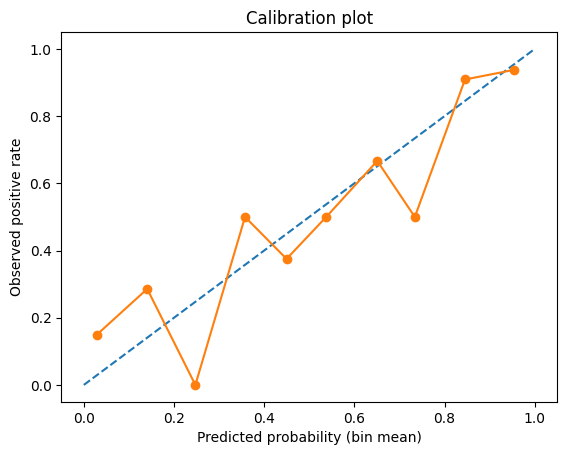

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

proba_test = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, proba_test)
ap  = average_precision_score(y_test, proba_test)
brier = brier_score_loss(y_test, proba_test)

print(f"AUC: {auc:.3f} | AP: {ap:.3f} | Brier: {brier:.3f}")

# Calibration via binning
bins = np.linspace(0, 1, 11)
df_eval = pd.DataFrame({"y": y_test.values, "p": proba_test})
df_eval["bin"] = pd.cut(df_eval["p"], bins=bins, include_lowest=True)
cal = df_eval.groupby("bin").agg(p_mean=("p","mean"), y_rate=("y","mean"), n=("y","size")).reset_index()

plt.figure()
plt.plot([0, 1], [0, 1], '--')
plt.plot(cal["p_mean"], cal["y_rate"], marker="o")
plt.xlabel("Predicted probability (bin mean)")
plt.ylabel("Observed positive rate")
plt.title("Calibration plot")
plt.show()


inference + quyết định

In [33]:
# inference + quyết định (Hot=0.6) + timing gate
def classify_decision(p):
    if p >= 0.6:
        return "Hot"
    if p >= 0.3:
        return "Warm"
    return "Cold"

pred_df = id_test.copy()
pred_df["probability"] = proba_test
pred_df["decision"] = pred_df["probability"].map(classify_decision)

# Lấy cờ season & large inflow từ X_test
test_view = X_test.join(id_test)
pred_df = pred_df.merge(
    test_view[["customer_id","season_flag","large_inflow_flag_7d"]],
    on="customer_id", how="left"
)

# Timing gate: ưu tiên khi vừa có large inflow hoặc đang mùa lễ
pred_df["season_priority"] = pred_df["season_flag"].isin(["pre_holiday","holiday_week"])
pred_df["priority_send"] = (pred_df["large_inflow_flag_7d"]==1) | (pred_df["season_priority"])

# Tóm tắt nhanh để kiểm tra tác động ngưỡng 0.6
summary = pred_df.groupby(["decision","priority_send"]).size().unstack(fill_value=0)
print(summary)
pred_df.head(10)


priority_send  False  True 
decision                   
Cold              17     16
Hot               19     30
Warm               7     11


,customer_id,year_month,probability,decision,season_flag,large_inflow_flag_7d,season_priority,priority_send
0,181,2025-08,0.943492,Hot,None,1,False,True
1,239,2025-08,0.543358,Warm,pre_holiday,0,True,True
2,216,2025-08,0.196825,Cold,holiday_week,0,True,True
3,299,2025-08,0.389911,Warm,holiday_week,1,True,True
4,377,2025-08,0.996963,Hot,None,0,False,False
5,427,2025-08,0.823656,Hot,None,0,False,False
6,279,2025-08,0.963492,Hot,holiday_week,1,True,True
7,302,2025-08,0.269883,Cold,holiday_week,1,True,True
8,97,2025-08,0.000000,Cold,holiday_week,0,True,True
9,175,2025-08,0.155716,Cold,None,0,False,False


export predictions to DATA_DIR

In [34]:
import os, json

# Chỉ giữ các cột cần thiết để tiêu thụ downstream
pred_out = pred_df[["customer_id", "probability", "decision", "priority_send"]].copy()

# Đường dẫn xuất
PRED_CSV  = os.path.join(DATA_DIR, "predictions.csv")
PRED_JSON = os.path.join(DATA_DIR, "predictions.jsonl")

# Ghi CSV
pred_out.to_csv(PRED_CSV, index=False)

# Ghi JSONL (mỗi dòng là một JSON record)
with open(PRED_JSON, "w", encoding="utf-8") as f:
    for _, r in pred_out.iterrows():
        f.write(json.dumps(r.to_dict(), ensure_ascii=False) + "\n")

print("Saved:")
print(" -", PRED_CSV)
print(" -", PRED_JSON)

pred_out.head(10)


Saved:
 - c:\Users\admin1\Downloads\hackathon\predictions.csv
 - c:\Users\admin1\Downloads\hackathon\predictions.jsonl


,customer_id,probability,decision,priority_send
0,181,0.943492,Hot,True
1,239,0.543358,Warm,True
2,216,0.196825,Cold,True
3,299,0.389911,Warm,True
4,377,0.996963,Hot,False
5,427,0.823656,Hot,False
6,279,0.963492,Hot,True
7,302,0.269883,Cold,True
8,97,0.000000,Cold,True
9,175,0.155716,Cold,False


Ablation Test để kiểm tra mô hình có phụ thuộc quá nhiều vào các feature timing không?

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd

# 1) Cột bỏ trong ablation
DROP_COLS = [
    "large_inflow_flag_7d", "days_since_large_inflow",
    "max_inflow_z_30d", "max_inflow_pct_30d", "inflow_baseline_90d",
    "season_flag"
]

# 2) Xây lại danh sách cột numeric / categorical cho ablation
CAT2 = []
if "segment" in X.columns and pd.api.types.is_object_dtype(X["segment"]):
    CAT2.append("segment")

NUM2 = [c for c in X.columns if c not in DROP_COLS + CAT2]

print("Ablation – categorical:", CAT2)
print("Ablation – numeric (sample):", NUM2[:8], "... (total:", len(NUM2), ")")

# 3) Preprocess cho ablation
transformers = [("num", Pipeline([("scaler", StandardScaler())]), NUM2)]
if len(CAT2) > 0:
    # Compat: sklearn <1.2 không có sparse_output
    try:
        ohe2 = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe2 = OneHotEncoder(handle_unknown="ignore", sparse=False)
    transformers.append(("cat", ohe2, CAT2))

pre2 = ColumnTransformer(transformers=transformers)

# 4) Model ablation (giữ isotonic calibration như bạn đang dùng)
base_lr2 = LogisticRegression(max_iter=500, n_jobs=-1)
cal_lr2 = CalibratedClassifierCV(estimator=base_lr2, method="isotonic", cv=5)

model2 = Pipeline([("preprocess", pre2), ("clf", cal_lr2)])

# 5) Fit & đánh giá
model2.fit(X_train[NUM2 + CAT2], y_train)
proba2 = model2.predict_proba(X_test[NUM2 + CAT2])[:, 1]
auc2 = roc_auc_score(y_test, proba2)
ap2  = average_precision_score(y_test, proba2)

print(f"Ablation (no inflow/season) -> AUC: {auc2:.3f} | AP: {ap2:.3f}")


Ablation – categorical: ['segment']
Ablation – numeric (sample): ['age', 'income', 'spend', 'balance_avg', 'loan', 'digital_logins_30d', 'incoming_tx_cnt_30d', 'outgoing_tx_cnt_30d'] ... (total: 31 )


Ablation (no inflow/season) -> AUC: 0.794 | AP: 0.818


ước lượng sai số thống kê khi test chỉ có 100 mẫu.

In [36]:
# bootstrap 95% CI for AUC on test set
from sklearn.utils import resample
import numpy as np

B = 500  # số lần bootstrap
aucs = []
y_np = y_test.values
p_np = proba_test.copy()

for _ in range(B):
    idx = resample(np.arange(len(y_np)), replace=True, n_samples=len(y_np), random_state=None)
    aucs.append(roc_auc_score(y_np[idx], p_np[idx]))

lo = np.percentile(aucs, 2.5)
hi = np.percentile(aucs, 97.5)
print(f"AUC bootstrap 95% CI: [{lo:.3f}, {hi:.3f}]  (B={B})")


AUC bootstrap 95% CI: [0.730, 0.903]  (B=500)


tạo "facts" từ top-factors

In [37]:
# Surrogate LR + Top-k factors + FACT catalog (pos/neg) + facts by contribution sign

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import set_config

# 1) Dùng preprocessor đã fit trong pipeline chính
prepped = model.named_steps["preprocess"]
set_config(transform_output="pandas")

# 2) Biến đổi train/test sang không gian đã preprocess (có tên cột rõ ràng num__/cat__)
Xt_train = prepped.transform(X_train)
Xt_test  = prepped.transform(X_test)
feat_names = list(Xt_train.columns)

# 3) Huấn luyện LR "surrogate" để có vector hệ số tuyến tính w
surrogate_lr = LogisticRegression(max_iter=500, n_jobs=-1)
surrogate_lr.fit(Xt_train, y_train)
coef = surrogate_lr.coef_.ravel()
coef_s = pd.Series(coef, index=feat_names)

# 4) FACT_CATALOG: mỗi feature có 2 câu: khi đóng góp dương (+) và khi đóng góp âm (-)
#    Quy ước: nếu contribution = (w * x) > 0 ⇒ dùng 'pos'; ngược lại dùng 'neg'.
FACT_CATALOG = {
    # tài chính cốt lõi
    "surplus": {
        "pos": "Dư thặng cao hỗ trợ khả năng chi trả",
        "neg": "Dư thặng thấp làm hạn chế khả năng chi trả"
    },
    "spend_ratio": {  # spend / income — thấp thì tốt
        "pos": "Tỷ lệ chi tiêu/thu nhập thấp cho thấy kỷ luật chi tiêu",
        "neg": "Tỷ lệ chi tiêu/thu nhập cao làm giảm dư địa tài chính"
    },
    "dti": {  # loan / income — thấp thì tốt
        "pos": "DTI thấp (nợ/thu nhập) phản ánh rủi ro trả nợ thấp",
        "neg": "DTI cao (nợ/thu nhập) làm tăng rủi ro tài chính"
    },
    "balance_ratio": {
        "pos": "Tỷ lệ số dư/thu nhập tốt",
        "neg": "Tỷ lệ số dư/thu nhập yếu"
    },
    "cashflow_volatility": {  # thấp thì tốt
        "pos": "Biến động dòng tiền thấp, ổn định",
        "neg": "Biến động dòng tiền cao, thiếu ổn định"
    },
    "failed_payments_90d": {  # thấp thì tốt
        "pos": "Ít giao dịch thất bại trong 90 ngày qua",
        "neg": "Nhiều giao dịch thất bại trong 90 ngày qua"
    },
    "liquidity_buffer": {
        "pos": "Đệm thanh khoản tốt",
        "neg": "Đệm thanh khoản mỏng"
    },
    "balance_trend_90d": {
        "pos": "Xu hướng số dư 3 tháng gần đây tích cực",
        "neg": "Xu hướng số dư 3 tháng gần đây suy giảm"
    },

    # hành vi giao dịch / digital
    "digital_index": {
        "pos": "Mức độ tương tác kênh số cao",
        "neg": "Mức độ tương tác kênh số thấp"
    },
    "digital_logins_30d": {
        "pos": "Tần suất đăng nhập ứng dụng ngân hàng số cao",
        "neg": "Tần suất đăng nhập ứng dụng ngân hàng số thấp"
    },
    "incoming_tx_cnt_30d": {
        "pos": "Nhiều giao dịch tiền vào gần đây",
        "neg": "Ít giao dịch tiền vào gần đây"
    },
    "outgoing_tx_cnt_30d": {
        "pos": "Hoạt động chi tiêu sôi động gần đây",
        "neg": "Hoạt động chi tiêu trầm gần đây"
    },

    # tín hiệu thời điểm
    "large_inflow_flag_7d": {
        "pos": "Vừa có khoản tiền vào lớn trong 7 ngày",
        "neg": "Gần đây không có khoản tiền vào lớn"
    },
    "max_inflow_z_30d": {
        "pos": "Có giao dịch tiền vào lớn bất thường gần đây",
        "neg": "Không có giao dịch tiền vào nổi bật gần đây"
    },
    "max_inflow_pct_30d": {
        "pos": "Tỷ lệ khoản tiền vào lớn so với trung bình cao",
        "neg": "Tỷ lệ khoản tiền vào lớn so với trung bình thấp"
    },
    "inflow_baseline_90d": {
        "pos": "Nền tiền vào 90 ngày tốt",
        "neg": "Nền tiền vào 90 ngày yếu"
    },

    # season one-hot (categorical)
    "season_flag_pre_holiday": {
        "pos": "Đang cận kỳ nghỉ lễ (nhu cầu tăng)",
        "neg": "Không cận kỳ nghỉ lễ"
    },
    "season_flag_holiday_week": {
        "pos": "Đang trong tuần nghỉ lễ (nhu cầu tăng)",
        "neg": "Không trong tuần nghỉ lễ"
    },

    # ví dụ thêm (tuỳ schema bạn có)
    "spend_travel": {
        "pos": "Chi tiêu cho du lịch gần đây đáng kể",
        "neg": "Chi tiêu cho du lịch gần đây hạn chế"
    },
}

def _normalize_feat_name(name: str) -> str:
    """
    Chuẩn hoá tên cột sau preprocess:
    - Bỏ prefix 'num__', 'cat__'
    - Giữ nguyên phần còn lại để tra FACT_CATALOG
    """
    if "__" in name:
        return name.split("__", 1)[1]
    return name

def _fact_from_feature(name: str, contribution: float) -> str | None:
    """
    Map tên feature (sau normalize) + dấu đóng góp -> câu fact.
    Trả None nếu không có trong FACT_CATALOG.
    """
    base = _normalize_feat_name(name)
    entry = FACT_CATALOG.get(base)
    if not entry:
        return None
    return entry["pos"] if contribution >= 0 else entry["neg"]

def top_factors_and_facts(x_raw: pd.Series, k: int = 3):
    """
    x_raw: 1 dòng trong X_test (chưa preprocess, cột = NUM_COLS + CAT_COLS)
    Trả về: (top_feature_names, facts_list)
      - top_feature_names: danh sách tên cột sau preprocess (num__/cat__)
      - facts_list       : danh sách câu fact đã map theo dấu đóng góp
    """
    # Biến đổi qua preprocessor để căn hàng cột với coef
    xt = prepped.transform(pd.DataFrame([x_raw], columns=X_test.columns))
    xt_row = xt.iloc[0]  # Series, index = feat_names

    # Đóng góp tuyến tính w·x
    contrib_vals = xt_row.values * coef
    contrib = pd.Series(contrib_vals, index=feat_names)

    # Chọn top-k theo |w·x|
    topk = contrib.abs().sort_values(ascending=False).head(k)
    topk_names = list(topk.index)

    # Dựng facts theo dấu contribution của từng feature
    facts = []
    for fname in topk_names:
        fact = _fact_from_feature(fname, contribution=contrib.loc[fname])
        if fact:
            facts.append(fact)

    # Loại trùng, giữ thứ tự
    facts = list(dict.fromkeys(facts))

    # Nếu không map được fact nào, trả fallback tối thiểu
    if len(facts) == 0:
        facts = ["Tôi không thể xác minh điều này."]

    return topk_names, facts

# 5) Xem thử 5 khách hàng đầu để xác minh
preview_rows = 5
examples = []
X_test_reset = X_test.reset_index(drop=True)
id_test_reset = id_test.reset_index(drop=True)

for i in range(min(preview_rows, len(X_test_reset))):
    topk, facts = top_factors_and_facts(X_test_reset.loc[i], k=3)
    examples.append({
        "customer_id": int(id_test_reset.loc[i, "customer_id"]),
        "top_features": ", ".join(topk),
        "facts": "; ".join(facts)
    })

pd.DataFrame(examples)


,customer_id,top_features,facts
0,181,"num__large_inflow_flag_7d, num__digital_logins...",Vừa có khoản tiền vào lớn trong 7 ngày; Tần su...
1,239,"num__dti, num__balance_ratio, num__digital_log...",DTI thấp (nợ/thu nhập) phản ánh rủi ro trả nợ ...
2,216,"num__dti, num__cashflow_volatility, cat__seaso...",DTI thấp (nợ/thu nhập) phản ánh rủi ro trả nợ ...
3,299,"num__liquidity_buffer, num__dti, num__balance_...",Đệm thanh khoản tốt; DTI cao (nợ/thu nhập) làm...
4,377,"num__cashflow_volatility, num__surplus, num__dti","Biến động dòng tiền thấp, ổn định; Dư thặng ca..."


Cấu hình Gemini + hàm sinh explanation từ facts (cell 13)

In [38]:
# Gemini call (simple prompt + retry backoff)
import os, time

try:
    import google.generativeai as genai
except Exception:
    genai = None

# Đọc API key từ env; nếu kernel chưa thấy (khởi động trước khi setx), thử nạp từ Windows User env
GEMINI_API_KEY = os.environ.get("GEMINI_API_KEY", "")
if not GEMINI_API_KEY:
    try:
        import sys
        if sys.platform.startswith("win"):
            import winreg
            with winreg.OpenKey(winreg.HKEY_CURRENT_USER, "Environment") as k:
                v, _ = winreg.QueryValueEx(k, "GEMINI_API_KEY")
                if v:
                    os.environ["GEMINI_API_KEY"] = v
                    GEMINI_API_KEY = v
                    print("ℹ️ Loaded GEMINI_API_KEY from Windows user env.")
    except Exception:
        pass

GEMINI_MODEL = os.environ.get("GEMINI_MODEL", "gemini-2.0-flash")

gemini_model = None
if genai is not None and GEMINI_API_KEY:
    try:
        genai.configure(api_key=GEMINI_API_KEY)
        gemini_model = genai.GenerativeModel(
            model_name=GEMINI_MODEL,
            generation_config={
                "temperature": 0.2,
                "max_output_tokens": 128,
            },
        )
        print(f"Gemini model initialized: {GEMINI_MODEL}")
    except Exception as e:
        print("Gemini init failed:", e)
else:
    print("Gemini not configured (missing package or GEMINI_API_KEY). Skipping LLM calls.")


def build_prompt(probability: float, decision: str, facts: list[str]) -> str:
    facts = [f for f in (facts or []) if isinstance(f, str) and f.strip()]
    if not facts or facts == ["Tôi không thể xác minh điều này."]:
        return "FACTS_INSUFFICIENT"
    return (
        "Chỉ dùng các facts sau để giải thích ngắn gọn (≤ 2 câu), không thêm thông tin mới.\n"
        f"- Quyết định: {decision}\n"
        f"- Xác suất: {probability:.2f}\n"
        "Facts:\n- " + "\n- ".join(facts)
    )


def llm_explain(probability: float, decision: str, facts: list[str]) -> str:
    # Nếu LLM chưa cấu hình, trả fallback an toàn
    if gemini_model is None:
        return "Tôi không có quyền truy cập thông tin đó."

    prompt = build_prompt(probability, decision, facts)
    if prompt == "FACTS_INSUFFICIENT":
        return "Tôi không thể xác minh điều này."
    # retry backoff cho 429
    for attempt in range(4):
        try:
            resp = gemini_model.generate_content(prompt)
            text = (getattr(resp, "text", "") or "").strip()
            return text if text else "Tôi không thể xác minh điều này."
        except Exception as e:
            msg = str(e)
            if "429" in msg and attempt < 3:
                time.sleep(1.5 * (attempt + 1))
                continue
            return "Tôi không thể xác minh điều này."


Gemini model initialized: gemini-2.0-flash


explanation cho toàn bộ test set

In [39]:
# test 1 customer_id, in cả facts và explanation (LLM)
import numpy as np
import pandas as pd

TEST_CUSTOMER_ID = 181

id_test_reset = id_test.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

mask = (id_test_reset["customer_id"] == TEST_CUSTOMER_ID)
if not mask.any():
    print("Không tìm thấy customer_id trong test set. Hãy đổi TEST_CUSTOMER_ID.")
else:
    pos = int(np.flatnonzero(mask)[0])  # vị trí 0..len(test)-1
    row_pred = pred_df.loc[pred_df["customer_id"] == TEST_CUSTOMER_ID]
    prob = float(row_pred["probability"].iloc[0])
    decision = str(row_pred["decision"].iloc[0])

    # Lấy facts từ top_k feature contributions (Cell 12)
    _, facts = top_factors_and_facts(X_test_reset.iloc[pos], k=3)

    # Gọi LLM (Cell 13) để sinh explanation
    explanation = llm_explain(probability=prob, decision=decision, facts=facts)

    print("customer_id:", TEST_CUSTOMER_ID)
    print("probability:", round(prob, 3))
    print("decision:", decision)
    print("facts:", facts)
    print("explanation:", explanation)


customer_id: 181
probability: 0.943
decision: Hot
facts: ['Vừa có khoản tiền vào lớn trong 7 ngày', 'Tần suất đăng nhập ứng dụng ngân hàng số cao', 'DTI thấp (nợ/thu nhập) phản ánh rủi ro trả nợ thấp']
explanation: Quyết định "Hot" có thể được đưa ra do khách hàng vừa có khoản tiền lớn, thường xuyên sử dụng ứng dụng ngân hàng số, và có DTI thấp, cho thấy khả năng tài chính tốt và ít rủi ro. Những yếu tố này kết hợp lại làm tăng xác suất (0.94) để đưa ra quyết định tích cực.


In [40]:
# import google.generativeai as genai

# mdl = genai.GenerativeModel("models/gemini-2.5-flash")
# resp = mdl.generate_content("Xin chào, hãy trả lời một câu bất kỳ để tôi test.")
# print(resp.text)


Record

In [41]:
# batch toàn bộ test set, lưu CSV gồm cả facts và explanation (LLM)
import os
import pandas as pd

id_test_reset = id_test.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

# Map nhanh để lấy prob/decision
pred_map = pred_df.set_index("customer_id")[["probability", "decision"]]

records = []
for pos in range(len(X_test_reset)):
    cust_id = int(id_test_reset.loc[pos, "customer_id"])
    if cust_id not in pred_map.index:
        continue

    prob = float(pred_map.loc[cust_id, "probability"])
    decision = str(pred_map.loc[cust_id, "decision"])

    # Facts từ Cell 12
    _, facts = top_factors_and_facts(X_test_reset.iloc[pos], k=3)

    # Explanation bằng LLM (Cell 13d)
    explanation = llm_explain(probability=prob, decision=decision, facts=facts)

    records.append({
        "customer_id": cust_id,
        "probability": prob,
        "decision": decision,
        "facts": "; ".join([f for f in facts if isinstance(f, str)]) if facts else "",
        "explanation": explanation
    })

pred_llm = pd.DataFrame(records)

OUT_CSV = os.path.join(DATA_DIR, "predictions_llm_with_facts.csv")
pred_llm.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)
pred_llm.head(10)


Saved: c:\Users\admin1\Downloads\hackathon\predictions_llm_with_facts.csv


,customer_id,probability,decision,facts,explanation
0,181,0.943492,Hot,Vừa có khoản tiền vào lớn trong 7 ngày; Tần su...,"Quyết định ""Hot"" có thể được đưa ra dựa trên x..."
1,239,0.543358,Warm,DTI thấp (nợ/thu nhập) phản ánh rủi ro trả nợ ...,"Quyết định ""Warm"" có thể được đưa ra do xác su..."
2,216,0.196825,Cold,DTI thấp (nợ/thu nhập) phản ánh rủi ro trả nợ ...,"Quyết định ""Cold"" có thể do xác suất thấp 0.20..."
3,299,0.389911,Warm,Đệm thanh khoản tốt; DTI cao (nợ/thu nhập) làm...,"Quyết định ""Warm"" có thể liên quan đến việc đệ..."
4,377,0.996963,Hot,"Biến động dòng tiền thấp, ổn định; Dư thặng ca...","Quyết định ""Hot"" được đưa ra vì biến động dòng..."
5,427,0.823656,Hot,Dư thặng cao hỗ trợ khả năng chi trả; Đệm than...,"Quyết định ""Hot"" có xác suất cao (0.82) vì dư ..."
6,279,0.963492,Hot,Vừa có khoản tiền vào lớn trong 7 ngày; DTI th...,"Quyết định ""Hot"" có thể được đưa ra do xác suấ..."
7,302,0.269883,Cold,Đệm thanh khoản mỏng; Vừa có khoản tiền vào lớ...,"Quyết định ""Cold"" có thể do đệm thanh khoản mỏ..."
8,97,0.000000,Cold,Chi tiêu cho du lịch gần đây hạn chế; Biến độn...,"Quyết định ""Cold"" có xác suất 0.00 vì chi tiêu..."
9,175,0.155716,Cold,DTI cao (nợ/thu nhập) làm tăng rủi ro tài chín...,"Quyết định ""Cold"" có thể do rủi ro tài chính c..."


In [47]:
# Upsert results to PostgreSQL (predictions, predictions_llm_with_facts) + metrics
from sqlalchemy import text
from uuid import uuid4

if not db_available():
    print("⚠️ Skip DB writes: DB not available.")
else:
    # 1) predictions
    if 'pred_df' in globals():
        # Lấy trực tiếp year_month có sẵn trong pred_df để tránh trùng cột khi merge
        if "year_month" not in pred_df.columns:
            raise KeyError("pred_df missing 'year_month'")
        tmp_pred = pred_df[["customer_id","year_month","probability","decision","priority_send"]].dropna(subset=["year_month"])
        sql_pred = text("""
            INSERT INTO predictions(customer_id, year_month, probability, decision, priority_send)
            VALUES (:customer_id, :year_month, :probability, :decision, :priority_send)
            ON CONFLICT (customer_id, year_month)
            DO UPDATE SET probability = EXCLUDED.probability,
                          decision    = EXCLUDED.decision,
                          priority_send = EXCLUDED.priority_send,
                          created_at  = now()
        """)
        with engine.begin() as conn:
            conn.execute(sql_pred, tmp_pred.to_dict(orient="records"))
        print("✅ Upserted predictions:", len(tmp_pred))
    else:
        print("ℹ️ pred_df/df not found; skip predictions upsert.")

    # 2) predictions_llm_with_facts
    if 'pred_llm' in globals():
        # Join sang pred_df để lấy year_month tương ứng
        if 'pred_df' in globals() and "year_month" in pred_df.columns:
            tmp_llm = pred_llm.merge(
                pred_df[["customer_id","year_month"]].drop_duplicates(),
                on="customer_id", how="left"
            )
        else:
            raise KeyError("Cannot resolve 'year_month' for pred_llm. 'pred_df' with year_month is required.")
        tmp_llm = tmp_llm.dropna(subset=["year_month"]) \
                         [["customer_id","year_month","probability","decision","facts","explanation"]]
        sql_llm = text("""
            INSERT INTO predictions_llm_with_facts(customer_id, year_month, probability, decision, facts, explanation)
            VALUES (:customer_id, :year_month, :probability, :decision, :facts, :explanation)
            ON CONFLICT (customer_id, year_month)
            DO UPDATE SET probability = EXCLUDED.probability,
                          decision    = EXCLUDED.decision,
                          facts       = EXCLUDED.facts,
                          explanation = EXCLUDED.explanation,
                          created_at  = now()
        """)
        with engine.begin() as conn:
            conn.execute(sql_llm, tmp_llm.to_dict(orient="records"))
        print("✅ Upserted predictions_llm_with_facts:", len(tmp_llm))
    else:
        print("ℹ️ pred_llm/df not found; skip predictions_llm_with_facts upsert.")

    # 3) metrics + calibration bins
    if all(name in globals() for name in ['auc','ap','brier']) and 'y_test' in globals():
        run_id = str(uuid4())
        train_size = int(len(y_train)) if 'y_train' in globals() else None
        test_size  = int(len(y_test))
        sql_metrics = text("""
            INSERT INTO model_metrics(run_id, train_size, test_size, auc, ap, brier)
            VALUES (:run_id, :train_size, :test_size, :auc, :ap, :brier)
        """)
        with engine.begin() as conn:
            conn.execute(sql_metrics, {
                "run_id": run_id,
                "train_size": train_size,
                "test_size": test_size,
                "auc": float(auc),
                "ap": float(ap),
                "brier": float(brier)
            })
        print("✅ Inserted model_metrics:", run_id)

        # Calibration bins if available
        if 'cal' in globals():
            recs = []
            for _, r in cal.iterrows():
                interval = r.get('bin')
                try:
                    low  = float(interval.left)
                    high = float(interval.right)
                except Exception:
                    low = None; high = None
                recs.append({
                    'run_id': run_id,
                    'bin_low': low,
                    'bin_high': high,
                    'p_mean': float(r['p_mean']),
                    'y_rate': float(r['y_rate']),
                    'n': int(r['n'])
                })
            if recs:
                sql_bins = text("""
                    INSERT INTO calibration_bins(run_id, bin_low, bin_high, p_mean, y_rate, n)
                    VALUES (:run_id, :bin_low, :bin_high, :p_mean, :y_rate, :n)
                """)
                with engine.begin() as conn:
                    conn.execute(sql_bins, recs)
                print("✅ Inserted calibration_bins:", len(recs))
    else:
        print("ℹ️ Metrics not available; skip metrics write.")



✅ Upserted predictions: 100
✅ Upserted predictions_llm_with_facts: 100
✅ Inserted model_metrics: c711c44c-357b-4627-bd38-e0c938bd7f60
✅ Inserted calibration_bins: 10
